# Libraries Import

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image

In [2]:
# ---------------------------
# 1. Dataset Loading & Preprocessing
# ---------------------------
# We use an ImageFolder dataset for CIFAR-10 images stored in folders.
# For this project we filter to only include the "cat" and "dog" classes.
dataset_path = "/kaggle/input/cifar10-pngs-in-folders/cifar10/train"
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    # Normalize to [-1, 1]
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
# Load the full dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
# Get indices for only "cat" and "dog"
selected_classes = ['cat', 'dog']
selected_indices = [i for i, (path, label) in enumerate(full_dataset.samples)
                    if full_dataset.classes[label] in selected_classes]
dataset = Subset(full_dataset, selected_indices)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

test_dataset_path = "/kaggle/input/cifar10-pngs-in-folders/cifar10/test"

# Use the same transform as for training.
test_full_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)

# Filter test dataset to include only "cat" and "dog" classes.
selected_classes = ['cat', 'dog']
test_selected_indices = [i for i, (path, label) in enumerate(test_full_dataset.samples)
                         if test_full_dataset.classes[label] in selected_classes]

test_dataset = Subset(test_full_dataset, test_selected_indices)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Test dataset loaded with {len(test_dataset)} samples.")

Using device: cuda
Test dataset loaded with 2000 samples.


In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=150, feature_map_size=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: (latent_dim) x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),
            # State: (feature_map_size*8) x 4 x 4
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),
            # State: (feature_map_size*4) x 8 x 8
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),
            # State: (feature_map_size*2) x 16 x 16
            nn.ConvTranspose2d(feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),
            # State: (feature_map_size) x 32 x 32
            nn.ConvTranspose2d(feature_map_size, 3, 3, 1, 1, bias=False),
            nn.Tanh()  # Output is in the range [-1, 1]
        )
    
    def forward(self, z):
        return self.net(z)
        
alpha_new = 1e-4                    # Lower scaling factor for the similarity score.
# Siamese Discriminator: Extract features from images and compute a similarity score.
class SiameseDiscriminator(nn.Module):
    def __init__(self, feature_map_size=64, alpha=alpha_new):
        super(SiameseDiscriminator, self).__init__()
        self.alpha = alpha
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, feature_map_size, 4, 2, 1),       # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size, feature_map_size*2, 4, 2, 1),  # 16x16 -> 8x8
            nn.BatchNorm2d(feature_map_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size*2, feature_map_size*4, 4, 2, 1),  # 8x8 -> 4x4
            nn.BatchNorm2d(feature_map_size*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def forward(self, img1, img2):
        # Extract features
        f1 = self.feature_extractor(img1)
        f2 = self.feature_extractor(img2)
        # Flatten features
        f1 = f1.view(f1.size(0), -1)
        f2 = f2.view(f2.size(0), -1)
        # Compute squared L2 distance
        diff = f1 - f2
        dist_sq = torch.sum(diff ** 2, dim=1, keepdim=True)
        # Scale the squared distance before exponentiation
        score = torch.exp(-self.alpha * dist_sq)
        return score

In [4]:
# ---------- 2.2 VAE Components -----------
class VAE(nn.Module):
    def __init__(self, latent_dim=512, feature_map_size=64):
        super(VAE, self).__init__()
        # Encoder: Input (3, 32, 32), output latent vector parameters
        self.encoder = nn.Sequential(
            nn.Conv2d(3, feature_map_size, 4, 2, 1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(feature_map_size, feature_map_size*2, 4, 2, 1),  # 16x16 -> 8x8
            nn.BatchNorm2d(feature_map_size*2),
            nn.ReLU(),
            nn.Conv2d(feature_map_size*2, feature_map_size*4, 4, 2, 1),  # 8x8 -> 4x4
            nn.BatchNorm2d(feature_map_size*4),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.feature_dim = feature_map_size*4*4*4  # Final feature map flattened
        self.fc_mu = nn.Linear(self.feature_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.feature_dim, latent_dim)
        
        # Decoder: Map latent vector to image
        self.fc_decode = nn.Linear(latent_dim, self.feature_dim)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (feature_map_size*4, 4, 4)),
            nn.ConvTranspose2d(feature_map_size*4, feature_map_size*2, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size*2),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map_size*2, feature_map_size, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map_size, 3, 4, 2, 1),
            nn.Tanh()  # Output in [-1,1]
        )
        
    def encode(self, x):
        x_enc = self.encoder(x)
        x_enc = self.flatten(x_enc)
        mu = self.fc_mu(x_enc)
        logvar = self.fc_logvar(x_enc)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [5]:
# ---------------------------
# 3. Loss Functions and Hyperparameters
# ---------------------------
# ----- For GAN using Minmax Loss (with similarity score) -----
epsilon = 1e-8  # To avoid log(0)
# For a given pair, D(x, y) is our similarity score as computed by SiameseDiscriminator.
# Define the minmax losses:
# For discriminator:

def ls_gan_discriminator_loss(D_real, D_fake):
    loss_real = torch.mean((D_real - 1.0)**2)
    loss_fake = torch.mean(D_fake**2)
    return 0.5 * (loss_real + loss_fake)

def ls_gan_generator_loss(D_fake):
    return 0.5 * torch.mean((D_fake - 1.0)**2)

In [6]:
# ----- For VAE: -----
# Use L1 loss (for sharper output) and KL divergence.
def vae_loss(recon, x, mu, logvar, kl_weight=0.01):
    recon_loss = nn.functional.l1_loss(recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_loss, recon_loss, kl_loss

# Updated hyperparameters for the GAN:
gan_latent_dim = 150                # Keep a higher latent dimension for richer detail.
alpha_new = 1e-4                    # Lower scaling factor for the similarity score.
lr_gen = 1e-4                       # Generator learning rate.
lr_disc = 1e-5                      # Further lower discriminator learning rate.
beta1 = 0.5

# Hyperparameters for VAE
# Updated hyperparameters for the VAE:
vae_latent_dim = 512            # You can experiment with even larger if your hardware allows.
lr_vae = 1e-5                   # Slightly increased learning rate from the previous very low rate.
kl_weight_new = 0.001           # Lower the KL divergence weight to let reconstructions be sharper.

# Use the same VAE architecture defined previously.
# In your VAE loss, update the weight:
def vae_loss(recon, x, mu, logvar, kl_weight=kl_weight_new):
    recon_loss = nn.functional.l1_loss(recon, x, reduction='sum')  # L1 loss tends to yield sharper images.
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_loss, recon_loss, kl_loss

In [7]:
# ---------------------------
# 4. Initialize Models and Optimizers
# ---------------------------
generator = Generator(latent_dim=gan_latent_dim).to(device)
discriminator = SiameseDiscriminator(alpha=alpha_new).to(device)

optimizerG = optim.Adam(generator.parameters(), lr=lr_gen, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(beta1, 0.999))


# VAE Model
vae = VAE(latent_dim=vae_latent_dim).to(device)
optimizerVAE = optim.Adam(vae.parameters(), lr=lr_vae)


In [8]:
# ---------------------------
# 5. Training Loop with Adversarial Update Strategy
# ---------------------------

gan_loss_history = {"G": [], "D": []}
num_epochs = 400

print("Starting GAN Training...")

for epoch in range(1, num_epochs + 1):
    update_discriminator = (epoch % 4 == 0)  # Only update discriminator every 4th epoch

    for i, (imgs, _) in enumerate(dataloader):
        batch_size = imgs.size(0)
        real_imgs = imgs.to(device)

        # Generate fake images from noise
        noise = torch.randn(batch_size, gan_latent_dim, 1, 1, device=device)
        fake_imgs = generator(noise)

        # ----------------------
        # Discriminator Update (ONLY every 4th epoch)
        # ----------------------
        if update_discriminator:
            D_real = discriminator(real_imgs, real_imgs)  # Similar = 1
            D_fake = discriminator(real_imgs, fake_imgs.detach())  # Similar = 0

            optimizerD.zero_grad()
            loss_D = ls_gan_discriminator_loss(D_real, D_fake)
            loss_D.backward()
            optimizerD.step()

            gan_loss_history["D"].append(loss_D.item())
        else:
            # Log last D loss again (or 0 if not yet started)
            gan_loss_history["D"].append(gan_loss_history["D"][-1] if gan_loss_history["D"] else 0)

        # ----------------------
        # Generator Update (EVERY epoch)
        # ----------------------
        noise = torch.randn(batch_size, gan_latent_dim, 1, 1, device=device)
        fake_imgs = generator(noise)
        D_fake = discriminator(real_imgs, fake_imgs)

        optimizerG.zero_grad()
        loss_G = ls_gan_generator_loss(D_fake)
        loss_G.backward()
        optimizerG.step()
        gan_loss_history["G"].append(loss_G.item())

        if i % 100 == 0:
            print(f"[GAN] Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                  f"Loss_G: {loss_G.item():.4f} "
                  f"{'Loss_D: ' + str(round(loss_D.item(), 4)) if update_discriminator else '(D skipped)'}")

    # Save sample outputs after every epoch
    sample_folder_gan = "gan_samples"
    os.makedirs(sample_folder_gan, exist_ok=True)

    with torch.no_grad():
        real_sample = real_imgs[:5]
        noise_sample = torch.randn(5, gan_latent_dim, 1, 1, device=device)
        fake_sample = generator(noise_sample)

        # Stack real + generated images
        grid = torchvision.utils.make_grid(torch.cat([real_sample, fake_sample], dim=0), nrow=5, normalize=True)
        save_image(grid, os.path.join(sample_folder_gan, f"epoch_{epoch}.png"))

print("GAN Training Completed.")

Starting GAN Training...
[GAN] Epoch [1/400] Batch [0/157] Loss_G: 0.0392 (D skipped)
[GAN] Epoch [1/400] Batch [100/157] Loss_G: 0.0250 (D skipped)
[GAN] Epoch [2/400] Batch [0/157] Loss_G: 0.0249 (D skipped)
[GAN] Epoch [2/400] Batch [100/157] Loss_G: 0.0236 (D skipped)
[GAN] Epoch [3/400] Batch [0/157] Loss_G: 0.0238 (D skipped)
[GAN] Epoch [3/400] Batch [100/157] Loss_G: 0.0227 (D skipped)
[GAN] Epoch [4/400] Batch [0/157] Loss_G: 0.0230 Loss_D: 0.314
[GAN] Epoch [4/400] Batch [100/157] Loss_G: 0.0419 Loss_D: 0.2616
[GAN] Epoch [5/400] Batch [0/157] Loss_G: 0.0426 (D skipped)
[GAN] Epoch [5/400] Batch [100/157] Loss_G: 0.0310 (D skipped)
[GAN] Epoch [6/400] Batch [0/157] Loss_G: 0.0310 (D skipped)
[GAN] Epoch [6/400] Batch [100/157] Loss_G: 0.0308 (D skipped)
[GAN] Epoch [7/400] Batch [0/157] Loss_G: 0.0293 (D skipped)
[GAN] Epoch [7/400] Batch [100/157] Loss_G: 0.0300 (D skipped)
[GAN] Epoch [8/400] Batch [0/157] Loss_G: 0.0297 Loss_D: 0.3011
[GAN] Epoch [8/400] Batch [100/157] Lo

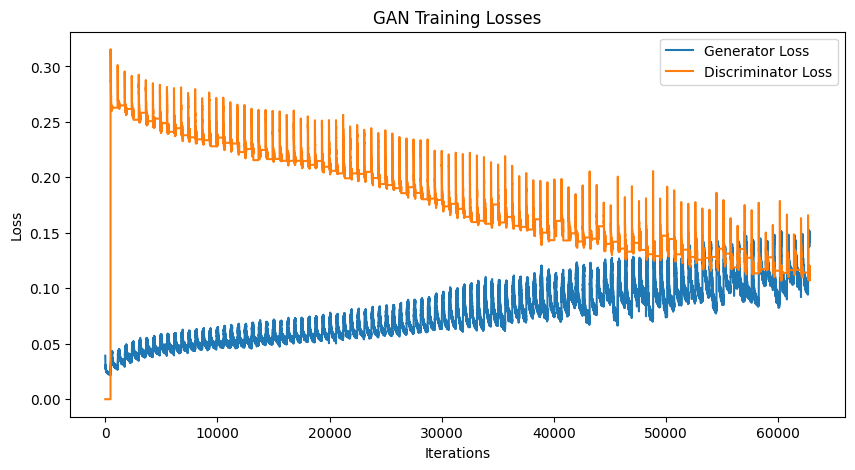

In [9]:
# Plot GAN Loss Curves
plt.figure(figsize=(10,5))
plt.plot(gan_loss_history["G"], label="Generator Loss")
plt.plot(gan_loss_history["D"], label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("GAN Training Losses")
plt.legend()
plt.show()

In [10]:
# ----- VAE Training Loop -----
vae_loss_history = {"total": [], "recon": [], "kl": []}
num_epochs_vae = 400  # set as needed

print("Starting VAE Training...")
vae.train()
for epoch in range(1, num_epochs_vae+1):
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        optimizerVAE.zero_grad()
        recon, mu, logvar = vae(imgs)
        total_loss, recon_loss, kl_loss = vae_loss(recon, imgs, mu, logvar, kl_weight=0.01)
        total_loss.backward()
        optimizerVAE.step()
        
        vae_loss_history["total"].append(total_loss.item())
        vae_loss_history["recon"].append(recon_loss.item())
        vae_loss_history["kl"].append(kl_loss.item())
        
        if i % 100 == 0:
            print(f"[VAE] Epoch [{epoch}/{num_epochs_vae}] Batch [{i}/{len(dataloader)}] Loss: {total_loss.item():.4f} Recon: {recon_loss.item():.4f} KL: {kl_loss.item():.4f}")
    # Optionally save reconstructed samples per epoch
    sample_folder_vae = "vae_samples"
    os.makedirs(sample_folder_vae, exist_ok=True)
    with torch.no_grad():
        recon, _, _ = vae(imgs)
        # Denormalize from [-1, 1] to [0,1]
        imgs_denorm = (imgs + 1) / 2
        recon_denorm = (recon + 1) / 2
        # Build a grid: top row originals, bottom row reconstructions
        n = min(8, imgs.size(0))
        grid_orig = torchvision.utils.make_grid(imgs_denorm[:n], nrow=n)
        grid_recon = torchvision.utils.make_grid(recon_denorm[:n], nrow=n)
        combined = torch.cat([grid_orig, grid_recon], dim=1)
        save_image(combined, os.path.join(sample_folder_vae, f"epoch_{epoch}.png"))
        
print("VAE Training Completed.")

Starting VAE Training...
[VAE] Epoch [1/400] Batch [0/157] Loss: 123787.5859 Recon: 123744.9141 KL: 4267.4473
[VAE] Epoch [1/400] Batch [100/157] Loss: 99315.0000 Recon: 99088.6953 KL: 22630.3203
[VAE] Epoch [2/400] Batch [0/157] Loss: 81793.0469 Recon: 81294.3750 KL: 49867.4609
[VAE] Epoch [2/400] Batch [100/157] Loss: 70381.4219 Recon: 69905.2344 KL: 47618.9375
[VAE] Epoch [3/400] Batch [0/157] Loss: 66135.5703 Recon: 65635.0625 KL: 50050.5117
[VAE] Epoch [3/400] Batch [100/157] Loss: 59342.9648 Recon: 58786.5430 KL: 55642.2383
[VAE] Epoch [4/400] Batch [0/157] Loss: 55266.6328 Recon: 54698.6641 KL: 56796.7148
[VAE] Epoch [4/400] Batch [100/157] Loss: 52235.4453 Recon: 51618.2578 KL: 61718.8594
[VAE] Epoch [5/400] Batch [0/157] Loss: 49500.9492 Recon: 48889.0547 KL: 61189.3281
[VAE] Epoch [5/400] Batch [100/157] Loss: 47339.4531 Recon: 46723.1328 KL: 61632.0391
[VAE] Epoch [6/400] Batch [0/157] Loss: 46200.7344 Recon: 45537.0156 KL: 66371.9922
[VAE] Epoch [6/400] Batch [100/157] Loss

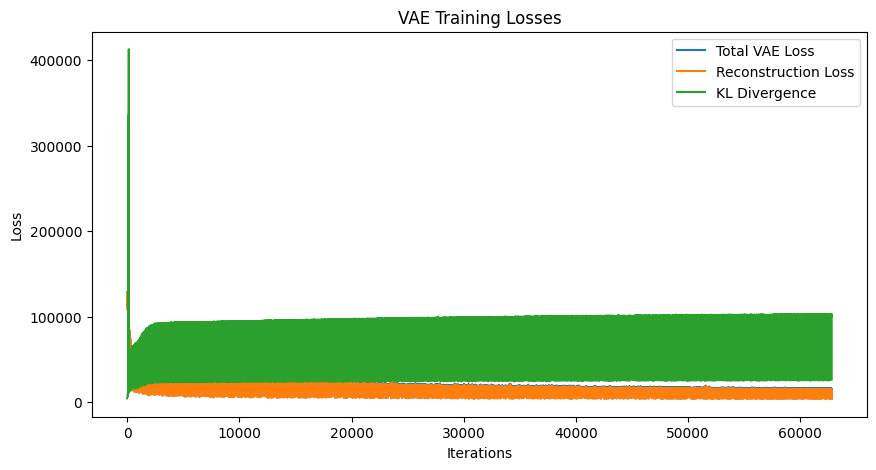

In [11]:
# Plot VAE Loss Curves
plt.figure(figsize=(10,5))
plt.plot(vae_loss_history["total"], label="Total VAE Loss")
plt.plot(vae_loss_history["recon"], label="Reconstruction Loss")
plt.plot(vae_loss_history["kl"], label="KL Divergence")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("VAE Training Losses")
plt.legend()
plt.show()

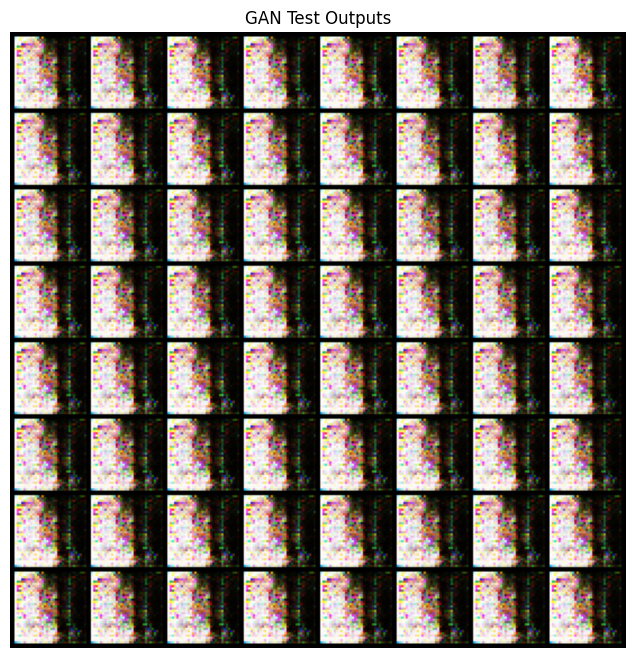

In [12]:
# ----- Testing GAN Outputs on Test Set -----
generator.eval()
with torch.no_grad():
    # Get a batch from the test loader.
    test_batch, _ = next(iter(test_dataloader))
    test_batch = test_batch.to(device)
    noise = torch.randn(test_batch.size(0), gan_latent_dim, 1, 1, device=device)
    fake_test = generator(noise)
    fake_test = (fake_test + 1) / 2  # Denormalize to [0,1]
    grid_test = make_grid(fake_test, nrow=8)
    
    plt.figure(figsize=(8,8))
    plt.title("GAN Test Outputs")
    plt.imshow(np.transpose(grid_test.cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()
    save_image(fake_test, "gan_test_outputs.png", nrow=8, normalize=True)

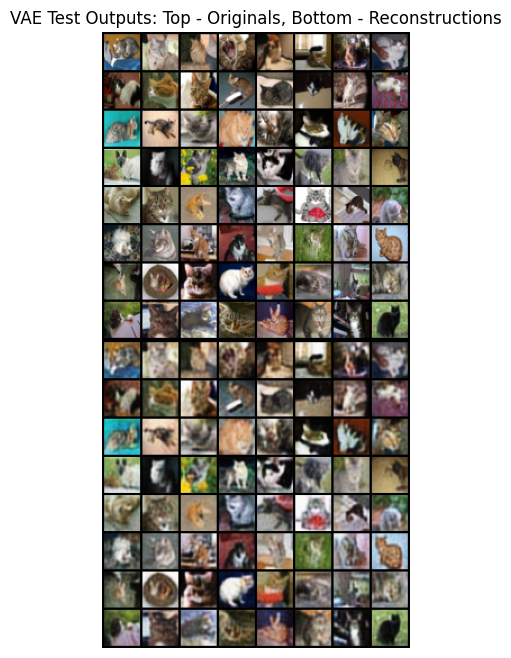

In [13]:
# ----- Testing VAE Outputs on Test Set -----
vae.eval()
with torch.no_grad():
    test_batch, _ = next(iter(test_dataloader))
    test_batch = test_batch.to(device)
    recon_test, _, _ = vae(test_batch)
    test_denorm = (test_batch + 1) / 2
    recon_denorm = (recon_test + 1) / 2
    grid_orig = make_grid(test_denorm, nrow=8)
    grid_recon = make_grid(recon_denorm, nrow=8)
    combined_test = torch.cat([grid_orig, grid_recon], dim=1)
    
    plt.figure(figsize=(16,8))
    plt.title("VAE Test Outputs: Top - Originals, Bottom - Reconstructions")
    plt.imshow(np.transpose(combined_test.cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()
    save_image(combined_test, "vae_test_outputs.png", normalize=True)